### In this recipe you will learn how to calculate the Ocean Heat Content (OHC).

The equation to calculate OHC is:

$\mathrm{OHC} = Cp \ \int_H^\eta T \ \rho \ dz$

where $Cp$ is the specific heat capacity of the seawater, $\rho$ is the density for every grid cell and $T$ is the water temperature.


Notes:
 - You will use [XROMS](https://github.com/xoceanmodel/xroms) to help you select the depth
 - It is expected the user to have access to a ROMS output


Fernando Sobral - 27th Feb 2025

In [1]:
import xroms
import matplotlib.pyplot as plt


In [2]:
# Just to avoid a warning froms xroms
import warnings
warnings.filterwarnings('ignore')


# Reading roms data
roms = xroms.open_netcdf('data/roms_ex_data/outer_avg_01461.nc')

In [21]:
# When reading the data with xroms, you already have z_rho calculated. z_rho is the time-varying depths of the s-layers in meters.
# We will use this information to mask depths deeper than the chosen depth to calculate the OHC.
# Let's calculate the OHC for the 700 m depth.

z_rho = roms.z_rho
temp700 = roms.temp.where(z_rho >= -700)


Text(0.5, 1.0, 'Temperature with depth')

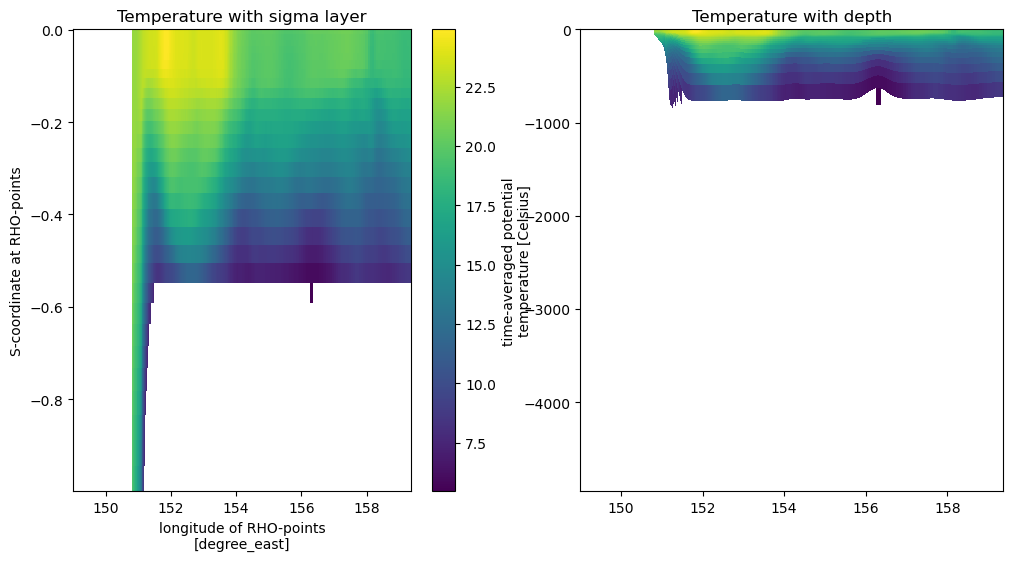

In [25]:
# Sanity check: plotting a zonal section to see if the mask is working

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Plotting temperature with sigma layer
temp700.isel(eta_rho=100, ocean_time=0).plot(ax=ax[0], x='lon_rho', y='s_rho')
ax[0].set_title('Temperature with sigma layer')

# Plotting temperature with depth
ax[1].pcolor(temp700.lon_rho.isel(eta_rho=100), z_rho.isel(eta_rho=100, ocean_time=0).values, temp700.isel(eta_rho=100, ocean_time=0).values)
ax[1].set_title('Temperature with depth')

In [ ]:
# Now that we know the mask is working, let's calculate the OHC

# Getting Metrics: we will use dz
dz = roms.dz

# Got the values from ROMS from /g/data/fu5/trunk/ROMS/Modules/mod_scalars.F 
Cp = 3985  # Specific heat capacity of seawater in J/(kg·°C)


# Calculate the OHC
ohc = Cp * rho * (temp700 * roms.dz).sum(dim='s_rho')
ohc